In [38]:
#using Plots
using CairoMakie
using RollingFunctions
using ProgressMeter
using LinearAlgebra
using DelaunayTriangulation
using DelimitedFiles
using MPI
include("Compass.jl")

main (generic function with 1 method)

In [ ]:
#tried all Z measurements but did not work
function Zs(N)
    Xarr = falses(N)
    Zarr = trues(N)
    return PauliOperator(0x00, Xarr, Zarr)
end

function Y_line(L)
    N = L^2
    Xarr = falses(N)
    Zarr = falses(N)
    for i in 1:L
        Xarr[i] = true
        Zarr[i] = true
    end
    return PauliOperator(0x00, Xarr, Zarr)
end

function initialize_state(L; method="prepared")
    if method == "prepared"
        N = L^2

        state = MixedDestabilizer(zero(Stabilizer, L^2))
        x, y, z = create_operators(L)
        yl = Y_line(L)
        zs = Zs(N)
        
        println(QuantumClifford.trusted_rank(state))

        #project all XX operators
        for i in 1:L
            for j in 1:L
                project!(state, x[i, j]; keep_result=false, phases=false)
            end
        end
        println(QuantumClifford.trusted_rank(state))
        #project all YY operators
        for k in 1:L
            for l in 1:L
                project!(state, y[k, l]; keep_result=false, phases=false)
            end
        end
        println(QuantumClifford.trusted_rank(state))

        #project a line of Y operators
        #project!(state, yl)
        project!(state,yl)
        println(QuantumClifford.trusted_rank(state))

        #if not full rank, throw an error
        if QuantumClifford.trusted_rank(state) != N
            error("Rank is not N")
        end

        return state
    elseif method == "mixed"
        return MixedDestabilizer(one(Stabilizer, L^2))
    elseif method == "zero"
        return MixedDestabilizer(zero(Stabilizer, L^2))
    else 
        error("Invalid method")
    end
end

initialize_state (generic function with 1 method)

In [184]:
function main2(p, L; initialize = "mixed", checkrank = false, check = false, keep_result=false, phases=false, iterations = 2000, thermalization = 500, between_measurements = 200) 
    X,Y,Z = create_operators(L)
    N = L^2
    dist  = Distributions.Categorical([p[1],p[2],p[3]])
    Sx = []
    Sy = []
    Tx = []
    Ty = []
    r = []
    #if initialize == "mixed"
    #    state = MixedDestabilizer(one(Stabilizer, N))
    #elseif initialize == "zero"
    #    state = MixedDestabilizer(zero(Stabilizer, N))
    #end

    state = initialize_state(L, method=initialize)

    
    #for i in length(X)
    #    project!(state, X[i], keep_result=false, phases=false)
    #end
    for i in 1:thermalization
        for j in 1:N
            xi = rand(1:L)
            yi = rand(1:L)

            ope = rand(dist)

            if ope == 1 #do X operation
                project!(state, X[xi,yi], keep_result=keep_result, phases=phases)
            elseif ope == 2 #do Y operation
                project!(state, Y[xi,yi], keep_result=keep_result, phases=phases)
            else #do Z operation
                yi = rand(1:Int(L/2))
                project!(state, Z[xi,yi], keep_result=keep_result, phases=phases)
            end
        end
        if checkrank == true
            push!(r, QuantumClifford.trusted_rank(state))
        end
        #if check == true
        #    println("trusted Rank = ", QuantumClifford.trusted_rank(state))
        #end
    end

    for _ in 1:iterations
        for _ in 1:N
            xi = rand(1:L)
            yi = rand(1:L)

            ope = rand(dist)

            if ope == 1 #do X operation
                project!(state, X[xi,yi], keep_result=false, phases=false)
            elseif ope == 2 #do Y operation
                project!(state, Y[xi,yi], keep_result=false, phases=false)
            else #do Z operation
                yi = rand(1:Int(L/2))
                project!(state, Z[xi,yi], keep_result=false, phases=false)
            end
        end
        push!(Sx, calc_EE(state, 1:Int(L/2), L, "x"))
        push!(Sy, calc_EE(state, 1:Int(L/2), L, "y"))
        push!(Tx, TMI(state, L, "x"))
        push!(Ty, TMI(state, L, "y"))
        push!(r, QuantumClifford.trusted_rank(state))
        for _ in 1:between_measurements
            for _ in 1:N
                xi = rand(1:L)
                yi = rand(1:L)

                ope = rand(dist)

                if ope == 1 #do X operation
                    project!(state, X[xi,yi], keep_result=false, phases=false)
                elseif ope == 2 #do Y operation
                    project!(state, Y[xi,yi], keep_result=false, phases=false)
                else #do Z operation
                    yi = rand(1:Int(L/2))
                    project!(state, Z[xi,yi], keep_result=false, phases=false)
                end
            end
        end
        GC.gc()
    end
    #println(QuantumClifford.trusted_rank(state))
    return Sx,Sy,Tx,Ty, r#, state
end

main2 (generic function with 1 method)

In [227]:
Sx_m, Sy_m, Tx_m, Ty_m, r_m = main2([0.1,0.9,0.0], 8;iterations = 100, thermalization = 0,between_measurements = 100, checkrank = true, initialize = "mixed")

(Any[1, 1, 3, 1, 1, 2, 2, 2, 1, 2  …  1, 1, 1, 1, 2, 1, 1, 1, 1, 1], Any[9, 5, 5, 5, 5, 5, 5, 5, 5, 5  …  5, 5, 5, 5, 5, 5, 5, 5, 5, 5], Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Any[1, 5, 5, 5, 5, 5, 5, 5, 5, 5  …  5, 5, 5, 5, 5, 5, 5, 5, 5, 5], Any[64, 64, 64, 64, 64, 64, 64, 64, 64, 64  …  64, 64, 64, 64, 64, 64, 64, 64, 64, 64])

In [228]:
Sx_p, Sy_p, Tx_p, Ty_p, r_p = main2([0.5,0.5,0.0], 8;iterations = 100, thermalization = 0,between_measurements = 100, checkrank = true, initialize = "prepared")

0
56
63
64


(Any[6, 9, 6, 7, 6, 6, 8, 11, 11, 9  …  7, 11, 9, 10, 5, 7, 5, 4, 11, 7], Any[7, 7, 2, 8, 9, 9, 3, 10, 4, 6  …  7, 8, 7, 6, 8, 9, 8, 7, 10, 7], Any[1, 4, 4, 1, 1, 1, 5, -1, 3, 0  …  1, 1, 2, 3, 2, 2, 1, 1, 0, 2], Any[6, 0, 1, -1, 3, 2, 0, 1, 2, -1  …  1, 0, -1, 0, 4, 2, 4, 2, -3, 2], Any[64, 64, 64, 64, 64, 64, 64, 64, 64, 64  …  64, 64, 64, 64, 64, 64, 64, 64, 64, 64])

In [226]:
Sx_z, Sy_z, Tx_z, Ty_z, r_z = main2([0.5,0.5,0.0], 8;iterations = 100, thermalization = 0,between_measurements = 100, checkrank = true, initialize = "zero")

(Any[19, 11, 9, 13, 11, 8, 8, 9, 10, 9  …  3, 10, 8, 5, 9, 8, 7, 8, 12, 7], Any[16, 9, 8, 9, 9, 10, 11, 8, 8, 7  …  10, 8, 10, 9, 9, 8, 10, 12, 11, 7], Any[0, 5, 3, 1, 0, 1, -1, 1, 3, -1  …  2, 0, 1, 3, 1, 4, 1, 2, -1, 2], Any[0, 1, 1, 0, 2, 2, 2, 3, 1, 1  …  6, 0, -1, 2, 5, 1, 4, 0, -3, 3], Any[31, 63, 63, 63, 63, 63, 63, 63, 63, 63  …  63, 63, 63, 63, 63, 63, 63, 63, 63, 63])

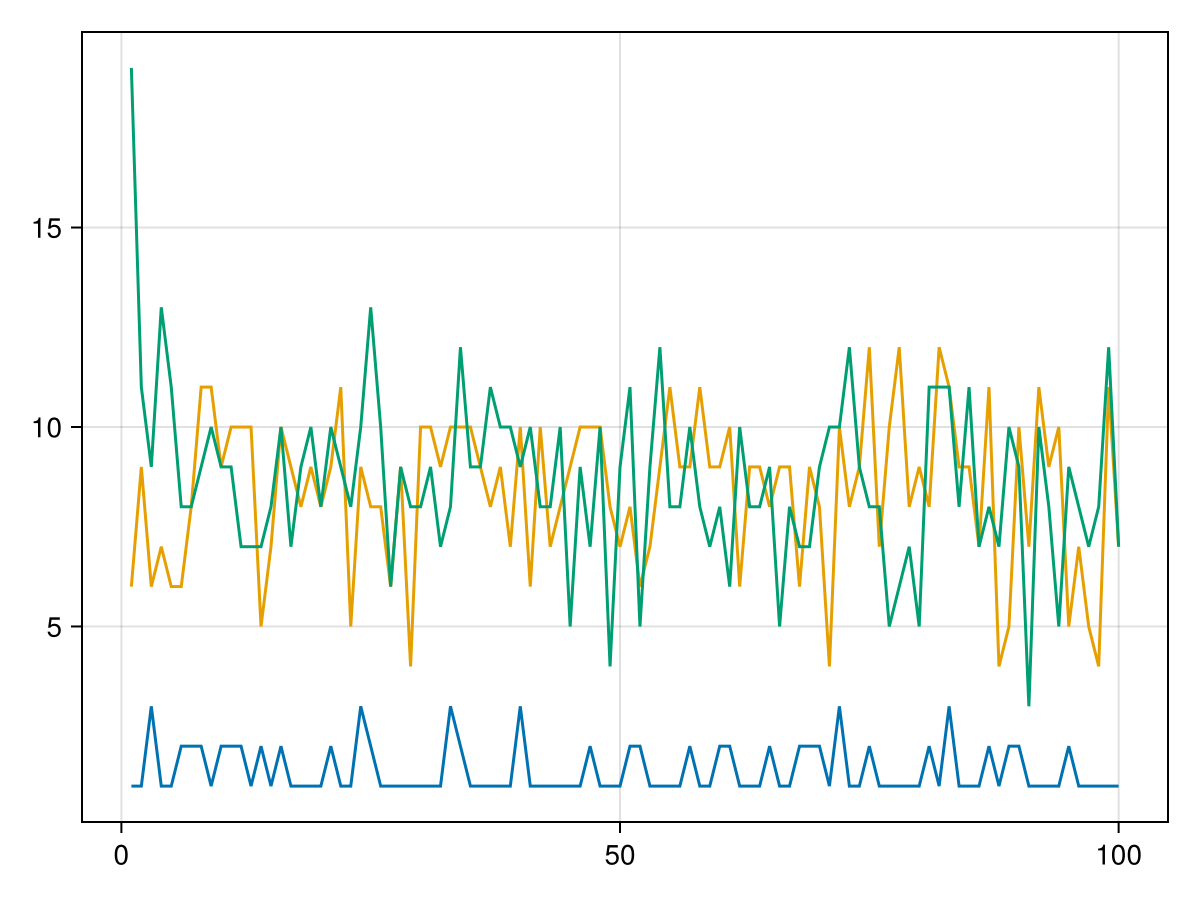

In [229]:
fig  = Figure()
ax = Axis(fig[1,1])
lines!(ax,Sx_m)
lines!(ax,Sx_p)
lines!(ax,Sx_z)
fig

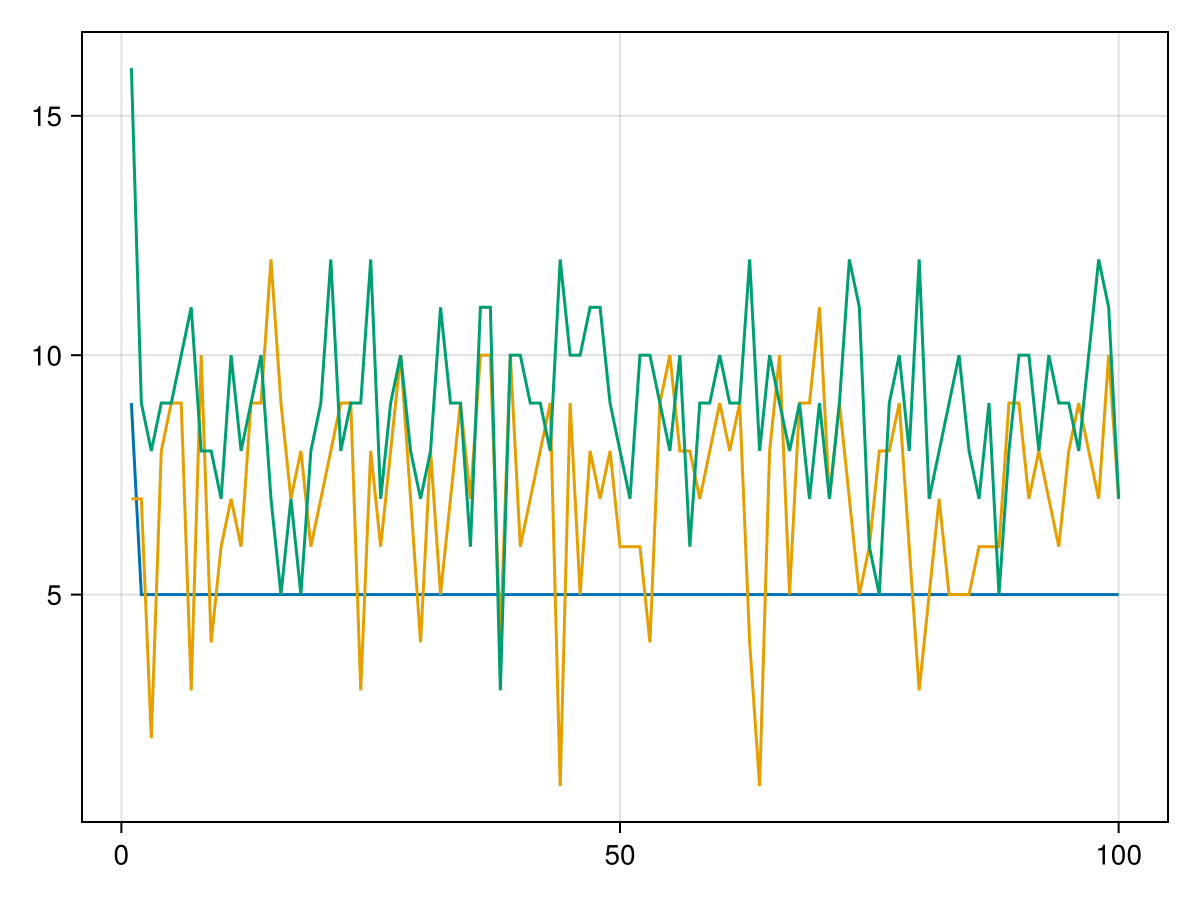

In [230]:
fig  = Figure()
ax = Axis(fig[1,1])
lines!(ax,Sy_m)
lines!(ax,Sy_p)
lines!(ax,Sy_z)
fig

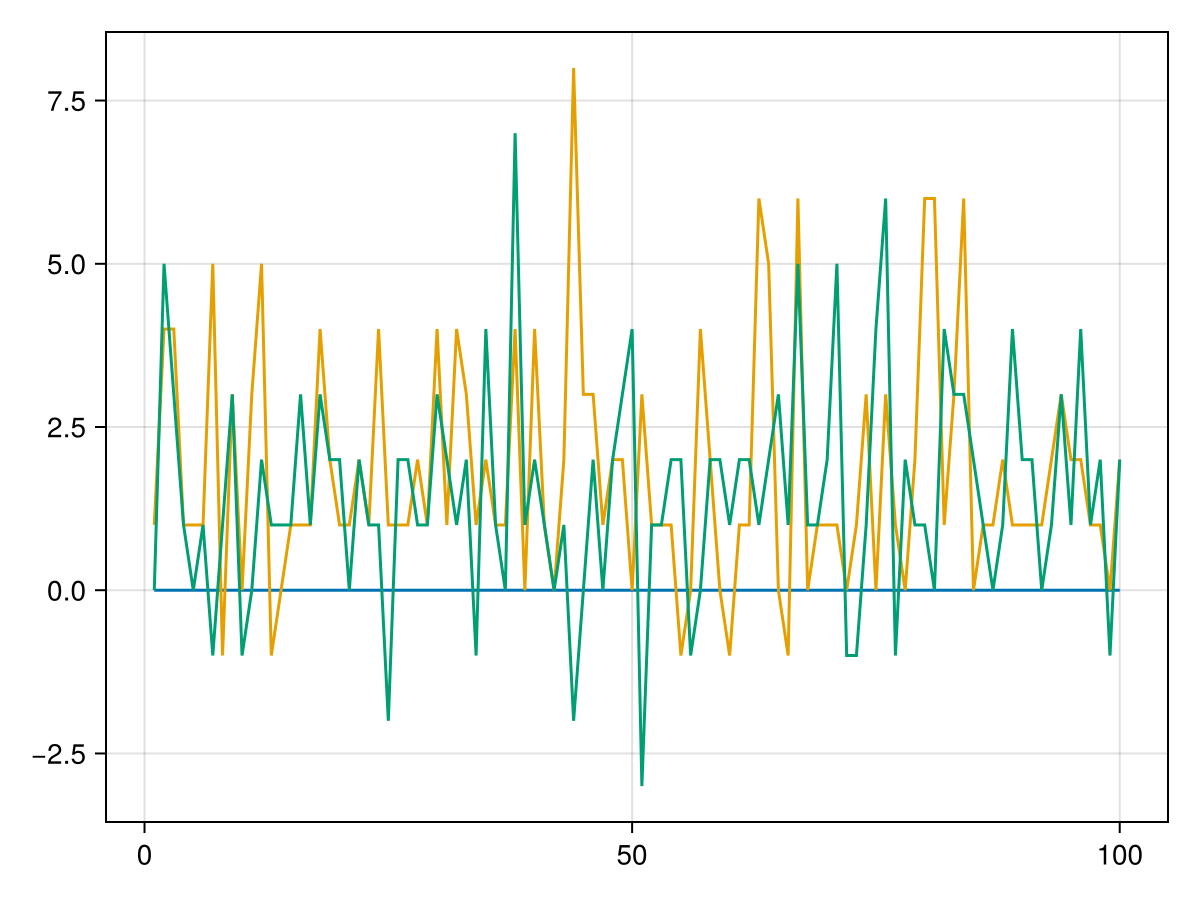

In [231]:
fig  = Figure()
ax = Axis(fig[1,1])
lines!(ax,Tx_m)
lines!(ax,Tx_p)
lines!(ax,Tx_z)
fig

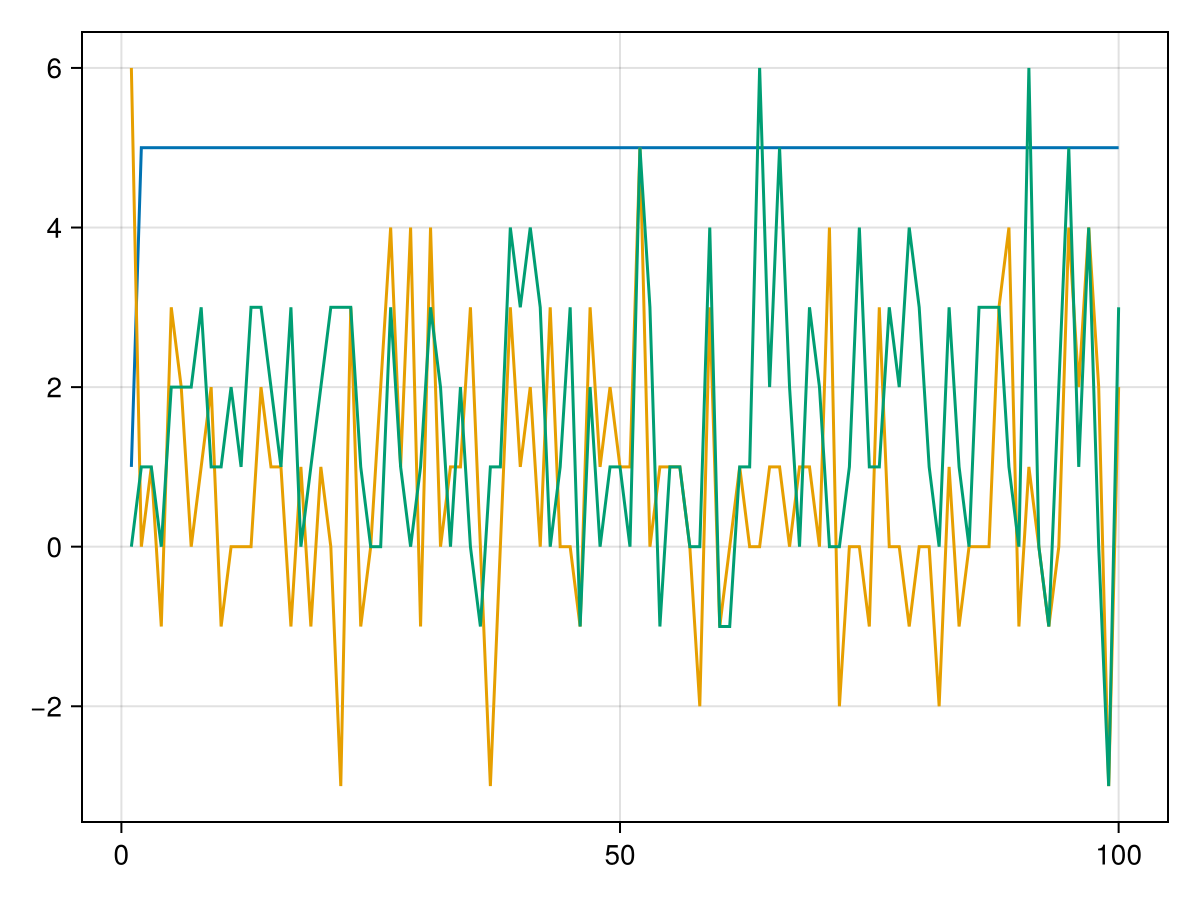

In [232]:
fig  = Figure()
ax = Axis(fig[1,1])
lines!(ax,Ty_m)
lines!(ax,Ty_p)
lines!(ax,Ty_z)
fig

In [239]:
mean(Sx_m), mean(Sx_p), mean(Sx_z)
var(Sx_m), var(Sx_p), var(Sx_z)

(0.36151515151515157, 3.722323232323235, 4.748585858585859)

In [237]:
mean(Sy_m), mean(Sy_p), mean(Sy_z)

(5.04, 7.18, 8.91)

In [236]:
mean(Tx_m), mean(Tx_p), mean(Tx_z)

(0.0, 1.81, 1.48)

In [235]:
mean(Ty_m), mean(Ty_p), mean(Ty_z)

(4.96, 0.79, 1.59)

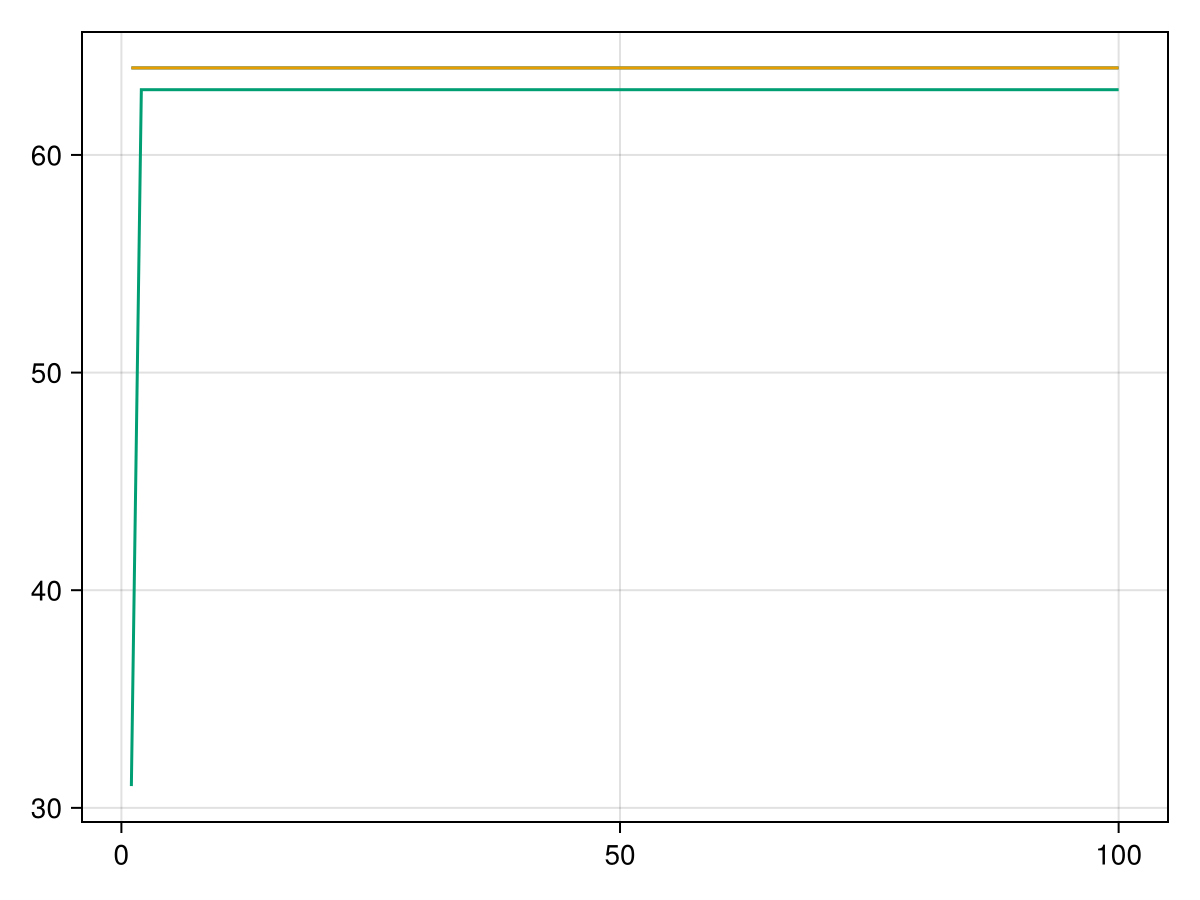

In [233]:
fig  = Figure()
ax = Axis(fig[1,1])
lines!(ax,r_m)
lines!(ax,r_p)
lines!(ax,r_z)
fig

In this document we are only interested in considering the XY-axis of the compass model and looking at different initializations of the state

In [ ]:
r = main2([0.5,0.5,0.0], 16;iterations = 0, thermalization = 100000,checkrank = true, initialize = "zero")[end-1]
r2 = main2([0.1,0.9,0.0], 16;iterations = 0, thermalization = 100000,checkrank = true, initialize = "zero")[end-1]
r3 = main2([0.1,0.1,0.8], 16;iterations = 0, thermalization = 100000,checkrank = true, initialize = "zero")[end-1]
r4 = main2([0,0,1], 16;iterations = 0, thermalization = 100000,checkrank = true, initialize = "zero")[end-1]
r5 = main2([0.33,0.33,0.34], 16;iterations = 0, thermalization = 100000,checkrank = true, initialize = "zero")[end-1]
r6 = main2([1,0,0], 16;iterations = 0, thermalization = 100000,checkrank = true, initialize = "zero")[end-1]
r7 = main2([0.2,0.2,0.6], 16;iterations = 0, thermalization = 100000,checkrank = true, initialize = "zero")[end-1]
r8 = main2([0.01,0.01,0.98], 16;iterations = 0, thermalization = 100000,checkrank = true, initialize = "zero")[end-1]


100000-element Vector{Any}:
 112
 124
 128
 128
 128
 128
 128
 128
 128
 128
   ⋮
 242
 242
 242
 242
 242
 242
 242
 242
 242

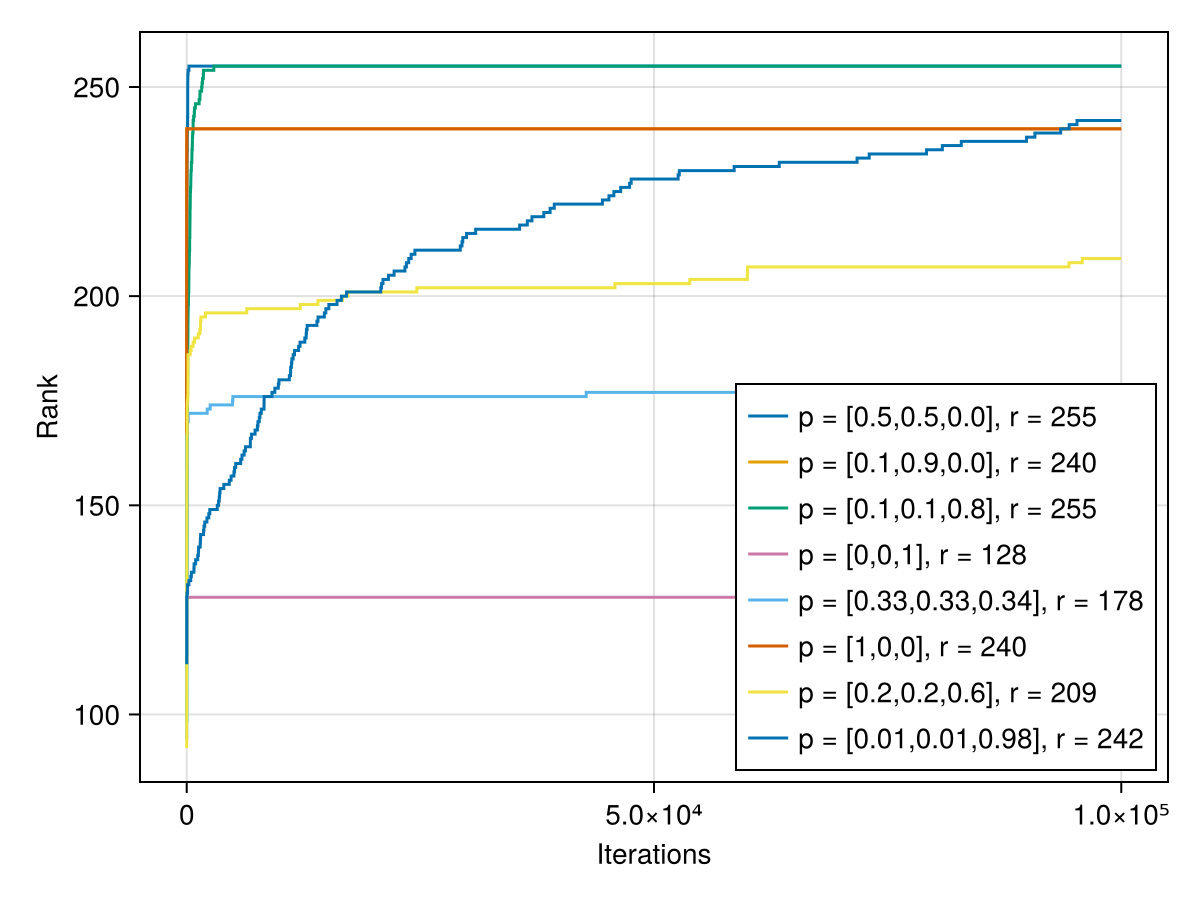

In [152]:
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax,r, label = "p = [0.5,0.5,0.0], r = $(r[end])")
lines!(ax,r2, label = "p = [0.1,0.9,0.0], r = $(r2[end])")
lines!(ax,r3, label = "p = [0.1,0.1,0.8], r = $(r3[end])")
lines!(ax,r4, label = "p = [0,0,1], r = $(r4[end])")
lines!(ax,r5, label = "p = [0.33,0.33,0.34], r = $(r5[end])")
lines!(ax,r6, label = "p = [1,0,0], r = $(r6[end])")
lines!(ax,r7, label = "p = [0.2,0.2,0.6], r = $(r7[end])")
lines!(ax,r8, label = "p = [0.01,0.01,0.98], r = $(r8[end])")
ax.ylabel = "Rank"
ax.xlabel = "Iterations"

axislegend(position = :rb)
#fig[1,2] = Legend(fig, ax, framevisible=false)
fig

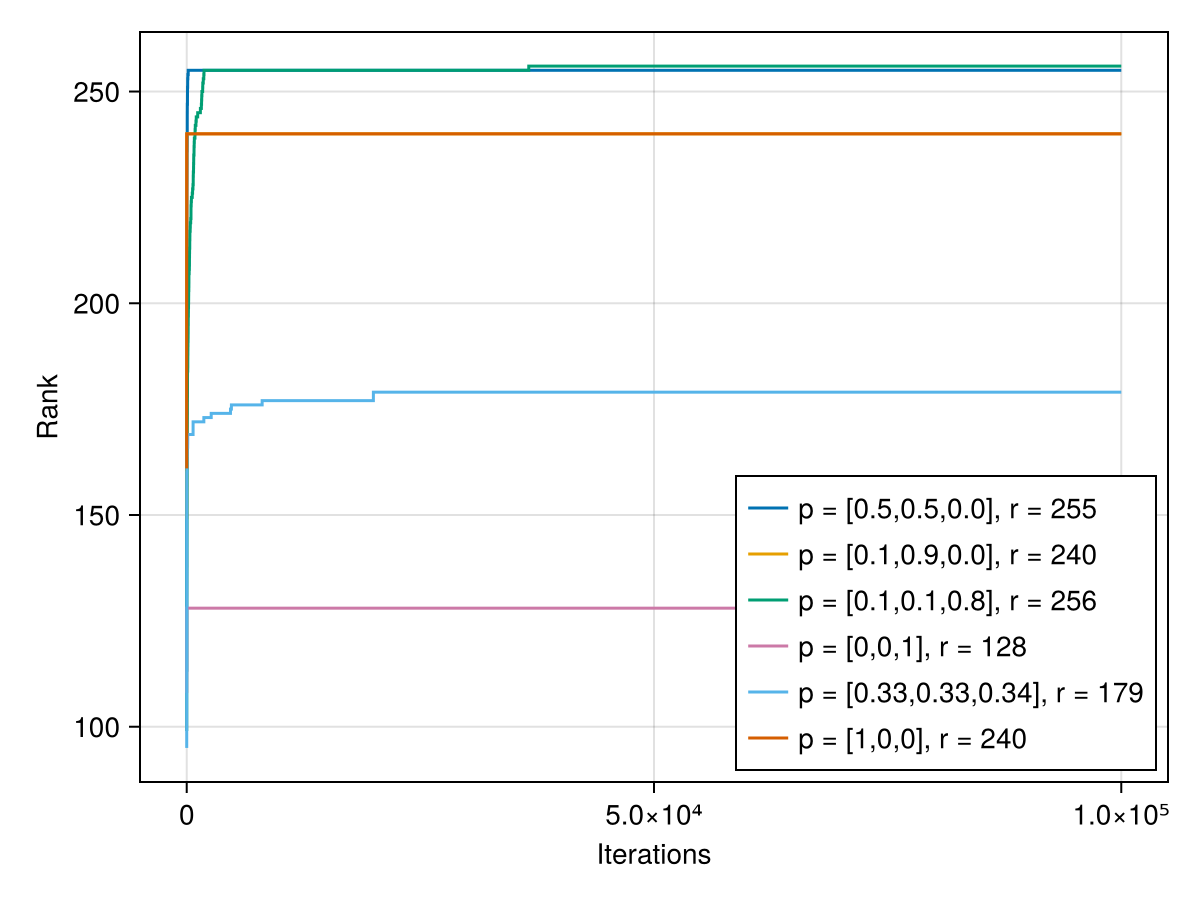

In [142]:
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax,r, label = "p = [0.5,0.5,0.0], r = $(r[end])")
lines!(ax,r2, label = "p = [0.1,0.9,0.0], r = $(r2[end])")
lines!(ax,r3, label = "p = [0.1,0.1,0.8], r = $(r3[end])")
lines!(ax,r4, label = "p = [0,0,1], r = $(r4[end])")
lines!(ax,r5, label = "p = [0.33,0.33,0.34], r = $(r5[end])")
lines!(ax,r6, label = "p = [1,0,0], r = $(r6[end])")
ax.ylabel = "Rank"
ax.xlabel = "Iterations"

axislegend(position = :rb)
#fig[1,2] = Legend(fig, ax, framevisible=false)
fig

In [ ]:
#save("rank_vs_iterations_2.png", fig)

CairoMakie.Screen{IMAGE}


In [175]:
therm = 10000
L = 8

8

In [176]:
r1_2 = main2([1,0,0.0], L;iterations = 0, thermalization = therm,checkrank = true, initialize = "zero")[end-1]
r2_2 = main2([0.9,0.1,0.0], L;iterations = 0, thermalization = therm,checkrank = true, initialize = "zero")[end-1]
r3_2 = main2([0.8,0.2,0], L;iterations = 0, thermalization = therm,checkrank = true, initialize = "zero")[end-1]
r3_21 = main2([0.7,0.3,0], L;iterations = 0, thermalization = therm,checkrank = true, initialize = "zero")[end-1]
r3_22 = main2([0.6,0.4,0], L;iterations = 0, thermalization = therm,checkrank = true, initialize = "zero")[end-1]
r4_2 = main2([0.52,0.48,0], L;iterations = 0, thermalization = therm,checkrank = true, initialize = "zero")[end-1]
r5_2 = main2([0.51,0.49,0], L;iterations = 0, thermalization = therm,checkrank = true, initialize = "zero")[end-1]
r6_2 = main2([0.53,0.47,0], L;iterations = 0, thermalization = therm,checkrank = true, initialize = "zero")[end-1]
r7_2 = main2([0.54,0.46,0], L;iterations = 0, thermalization = therm,checkrank = true, initialize = "zero")[end-1]
r8_2 = main2([0.55,0.45,0], L;iterations = 0, thermalization = therm,checkrank = true, initialize = "zero")[end-1]
r9_2 = main2([0.56,0.44,0], L;iterations = 0, thermalization = therm,checkrank = true, initialize = "zero")[end-1]

10000-element Vector{Any}:
 25
 35
 41
 44
 48
 56
 56
 56
 56
 56
  ⋮
 63
 63
 63
 63
 63
 63
 63
 63
 63

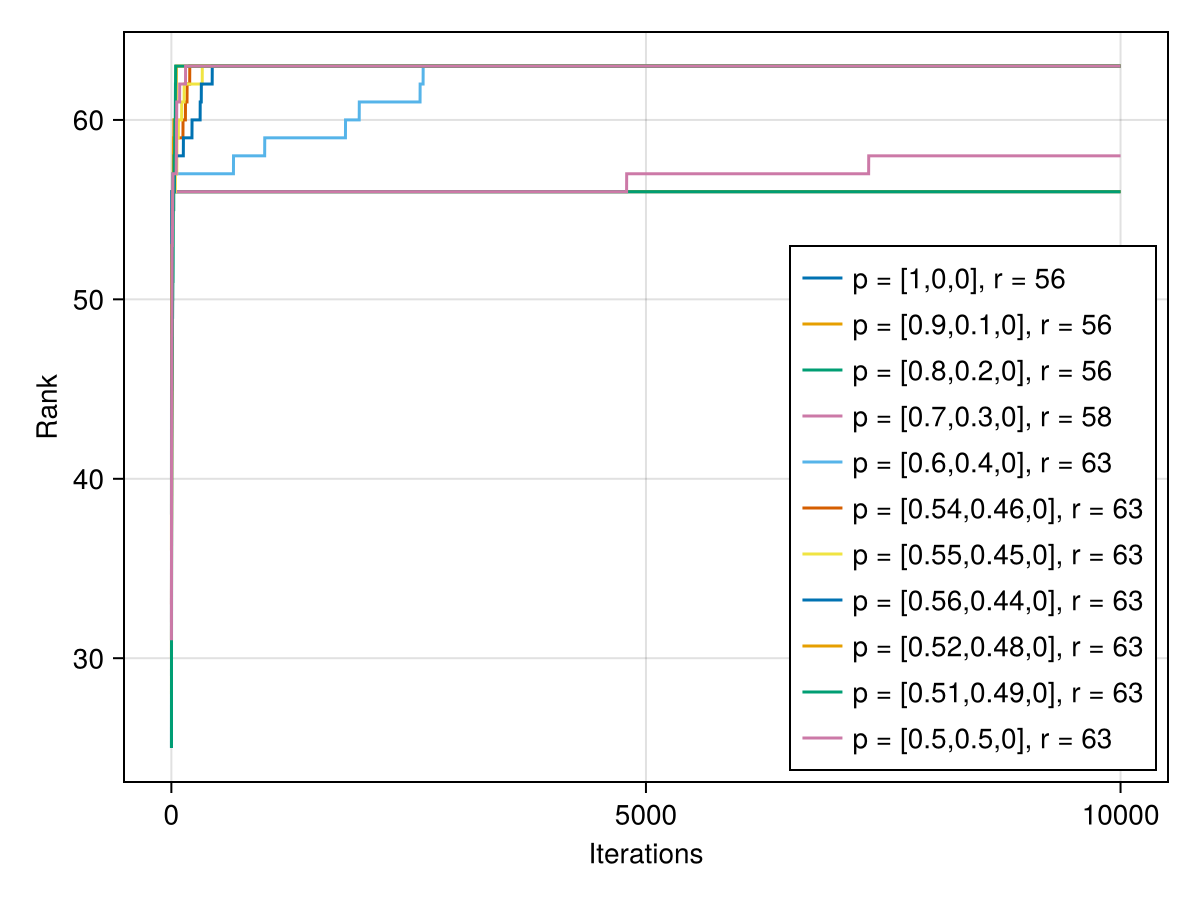

In [177]:
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax,r1_2, label = "p = [1,0,0], r = $(r1_2[end])")
lines!(ax,r2_2, label = "p = [0.9,0.1,0], r = $(r2_2[end])")
lines!(ax,r3_2, label = "p = [0.8,0.2,0], r = $(r3_2[end])")
lines!(ax,r3_21, label = "p = [0.7,0.3,0], r = $(r3_21[end])")
lines!(ax,r3_22, label = "p = [0.6,0.4,0], r = $(r3_22[end])")
lines!(ax,r7_2, label = "p = [0.54,0.46,0], r = $(r7_2[end])")
lines!(ax,r8_2, label = "p = [0.55,0.45,0], r = $(r8_2[end])")
lines!(ax,r9_2, label = "p = [0.56,0.44,0], r = $(r9_2[end])")
lines!(ax,r4_2, label = "p = [0.52,0.48,0], r = $(r4_2[end])")
lines!(ax,r5_2, label = "p = [0.51,0.49,0], r = $(r5_2[end])")
lines!(ax,r6_2, label = "p = [0.5,0.5,0], r = $(r6_2[end])")
ax.ylabel = "Rank"
ax.xlabel = "Iterations"

axislegend(position = :rb)
#fig[1,2] = Legend(fig, ax, framevisible=false)
fig

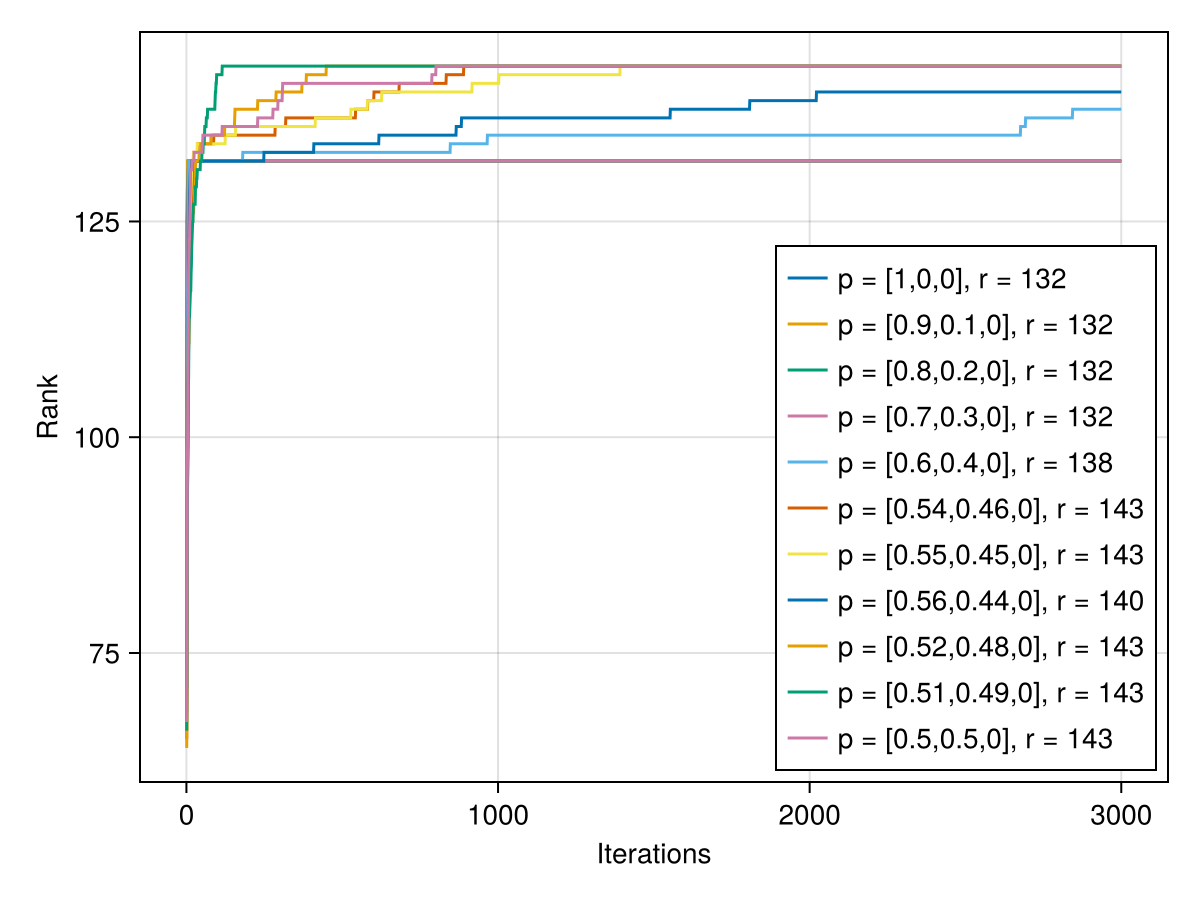

In [171]:
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax,r1_2, label = "p = [1,0,0], r = $(r1_2[end])")
lines!(ax,r2_2, label = "p = [0.9,0.1,0], r = $(r2_2[end])")
lines!(ax,r3_2, label = "p = [0.8,0.2,0], r = $(r3_2[end])")
lines!(ax,r3_21, label = "p = [0.7,0.3,0], r = $(r3_21[end])")
lines!(ax,r3_22, label = "p = [0.6,0.4,0], r = $(r3_22[end])")
lines!(ax,r7_2, label = "p = [0.54,0.46,0], r = $(r7_2[end])")
lines!(ax,r8_2, label = "p = [0.55,0.45,0], r = $(r8_2[end])")
lines!(ax,r9_2, label = "p = [0.56,0.44,0], r = $(r9_2[end])")
lines!(ax,r4_2, label = "p = [0.52,0.48,0], r = $(r4_2[end])")
lines!(ax,r5_2, label = "p = [0.51,0.49,0], r = $(r5_2[end])")
lines!(ax,r6_2, label = "p = [0.5,0.5,0], r = $(r6_2[end])")
ax.ylabel = "Rank"
ax.xlabel = "Iterations"

axislegend(position = :rb)
#fig[1,2] = Legend(fig, ax, framevisible=false)
fig

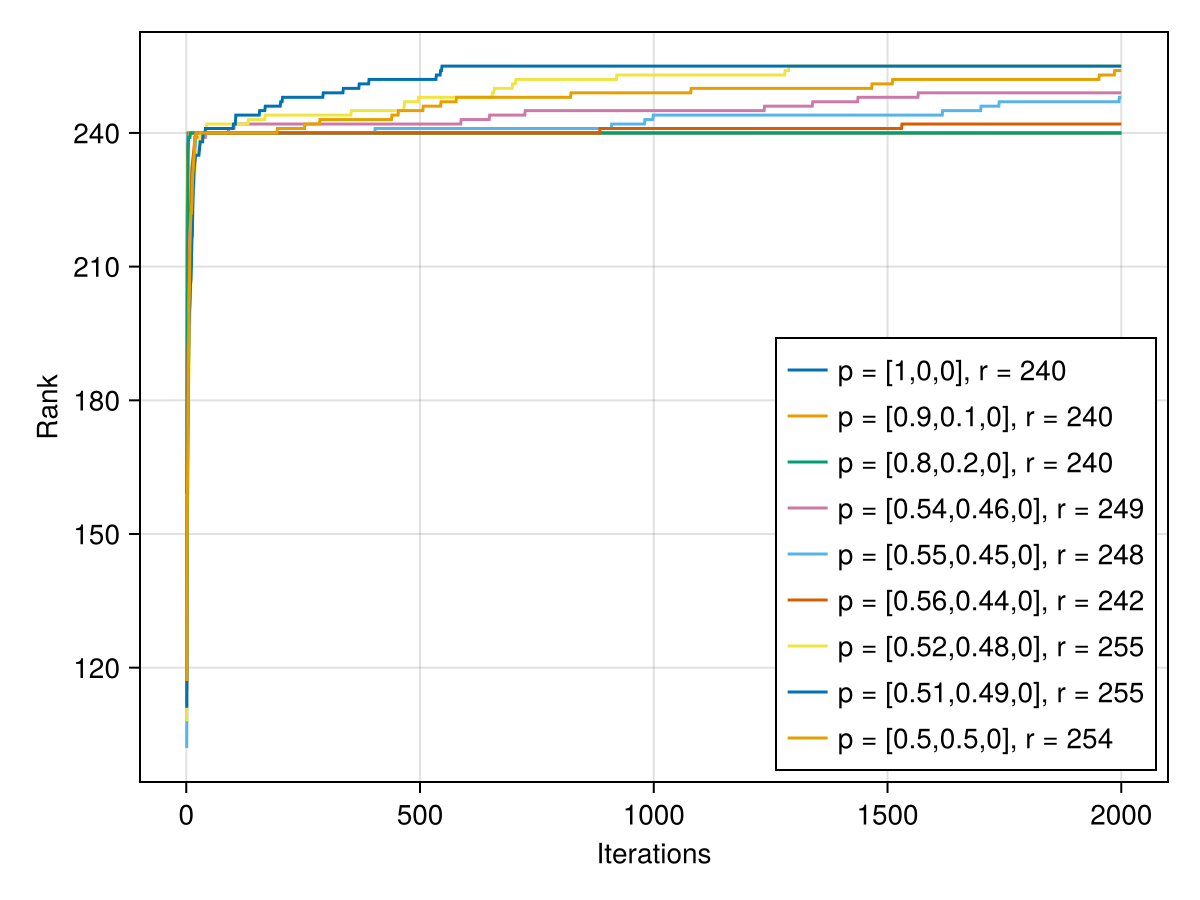

In [165]:
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax,r1_2, label = "p = [1,0,0], r = $(r1_2[end])")
lines!(ax,r2_2, label = "p = [0.9,0.1,0], r = $(r2_2[end])")
lines!(ax,r3_2, label = "p = [0.8,0.2,0], r = $(r3_2[end])")
lines!(ax,r7_2, label = "p = [0.54,0.46,0], r = $(r7_2[end])")
lines!(ax,r8_2, label = "p = [0.55,0.45,0], r = $(r8_2[end])")
lines!(ax,r9_2, label = "p = [0.56,0.44,0], r = $(r9_2[end])")
lines!(ax,r4_2, label = "p = [0.52,0.48,0], r = $(r4_2[end])")
lines!(ax,r5_2, label = "p = [0.51,0.49,0], r = $(r5_2[end])")
lines!(ax,r6_2, label = "p = [0.5,0.5,0], r = $(r6_2[end])")
ax.ylabel = "Rank"
ax.xlabel = "Iterations"

axislegend(position = :rb)
#fig[1,2] = Legend(fig, ax, framevisible=false)
fig

When initializing the totally mixed state, even after many steps, one does not reach full rank. The highest rank is reached for p = [0.5,0.5,0], namely L^2-1. 

If one measurement type dominates over the others, the maximal rank reached is 240 for L = 16 for XX and YY, and 128 for ZZ measurements.

First way of initializing ist to just initialize the totally mixed state

The second way to initialize is to just thermalize for as long as the rank reaches L^2.

initialize_state (generic function with 1 method)

In [ ]:
function simulate

0
240
255
255


ErrorException: Rank is not N